In [67]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay, precision_score, recall_score
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Flatten, Reshape, Dropout, Conv1D
from keras.regularizers import L1L2
from sklearn.utils import resample

In [2]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:06:00.0, compute capability: 8.6



In [3]:
shuffled_folder = 'dataset/shuffled/'
shuffled_files = [shuffled_folder + file for file in os.listdir(shuffled_folder)]
random.shuffle(shuffled_files)

In [4]:
num_files = len(shuffled_files)
training_cut = round(0.4 * num_files)
cross_cut = round(0.7 * num_files)

In [5]:
training_files = shuffled_files[:training_cut]
cross_validation_files = shuffled_files[training_cut:cross_cut]
test_files = shuffled_files[cross_cut:]

In [6]:
def get_train_test_dfs(file):
    df = pd.read_parquet(file)
    df = df.fillna(0)
    X = df[[i for i in df.columns if not i == 'label']]
    y = df[['label']]
    return train_test_split(X, y, test_size=0.3, stratify=y)

In [21]:
X_train, X_test, y_train, y_test = get_train_test_dfs('dataset/shuffled/part_6')

In [8]:
def check_distrib(df):
    df = df[['label']]
    ones = len(df[df['label'] == 1])
    return ones / len(df)

In [22]:
len(X_train), len(y_train), len(X_test), len(y_test)

(6587395, 6587395, 2823170, 2823170)

In [23]:
check_distrib(y_train), check_distrib(y_test)

(0.739918890547781, 0.7399189563504854)

In [11]:
def plot_confusion_matrix(y_true, y_pred):
    conf_mat = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred))
    conf_mat.plot()

---

In [134]:
model = Sequential()
model.add(Dense(units=50, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=200, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
# model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

In [135]:
model.fit(X_train, y_train)

205857/205857 [==============================] - 1329s 6ms/step - loss: 0.5440 - precision_9: 0.7402 - false_positives_9: 428465.3804 - true_negatives_9: 0.0000e+00


In [136]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8505211735867056
Precision = 0.7399189563504854 



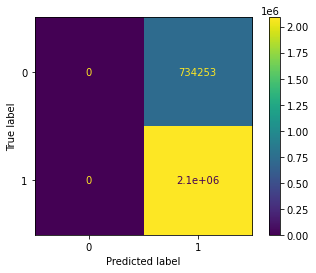

In [141]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [142]:
model = Sequential()
model.add(Dense(units=1, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.TrueNegatives()])

In [143]:
model.fit(X_train, y_train)

205857/205857 [==============================] - 1000s 5ms/step - loss: 0.5434 - precision_10: 0.7406 - false_positives_10: 427910.3043 - true_negatives_10: 123.5893


In [144]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8506587435005278
Precision = 0.74014111430911 



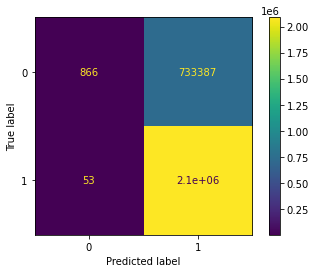

In [145]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

---

### Try undersampling

In [32]:
def shuffle_df(df):
    return df.sample(frac=1).reset_index(drop=True)

In [70]:
X_train, X_test, y_train, y_test = get_train_test_dfs('dataset/shuffled/part_6')

In [71]:
len(X_train), len(y_train), len(X_test), len(y_test)

(6587395, 6587395, 2823170, 2823170)

In [72]:
check_distrib(y_train), check_distrib(y_test)

(0.739918890547781, 0.7399189563504854)

In [73]:
train = pd.concat([X_train, y_train], axis=1)

In [74]:
negative = train[train['label'] == 0]
positive = train[train['label'] == 1]

In [75]:
len(negative), len(positive)

(1713257, 4874138)

In [76]:
positive = shuffle_df(positive).iloc[:len(negative)]

In [77]:
train = pd.concat([positive, negative])

In [78]:
train = shuffle_df(train)

In [79]:
X_train = train[[i for i in train.columns if i != 'label']]
y_train = train[['label']]

In [80]:
len(X_train)

3426514

In [81]:
check_distrib(y_train)

0.5

In [82]:
model = Sequential()
model.add(Dense(units=1, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision()])

In [83]:
model.fit(X_train, y_train)

107079/107079 [==============================] - 537s 5ms/step - loss: 0.6484 - recall_3: 0.1939 - false_negatives: 367743.4495 - precision_5: 0.8413


In [84]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.23103900739399005
Precision = 0.999875396714871 

Recall = 0.13060930616199687 



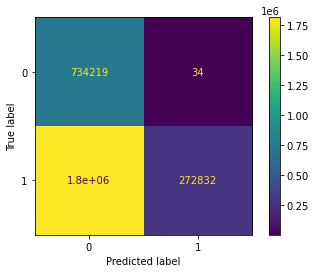

In [85]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [86]:
model = Sequential()
model.add(Dense(units=50, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=200, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
# model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision()])

In [87]:
model.fit(X_train, y_train)

107079/107079 [==============================] - 698s 6ms/step - loss: 0.6472 - recall_4: 0.1375 - false_negatives_1: 371654.1647 - precision_6: 0.9643


In [88]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.23101133034482205
Precision = 0.999989002690675 

Recall = 0.13058967876655703 



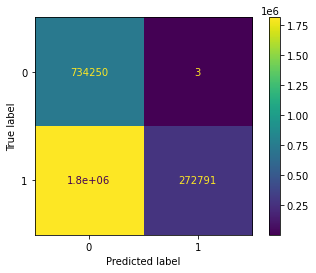

In [89]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

---

### Try oversampling

In [100]:
X_train, X_test, y_train, y_test = get_train_test_dfs('dataset/shuffled/part_6')

In [101]:
len(X_train), len(y_train), len(X_test), len(y_test)

(6587395, 6587395, 2823170, 2823170)

In [102]:
check_distrib(y_train), check_distrib(y_test)

(0.739918890547781, 0.7399189563504854)

In [103]:
train = pd.concat([X_train, y_train], axis=1)
negative = train[train['label'] == 0]
positive = train[train['label'] == 1]

In [104]:
len(negative), len(positive)

(1713257, 4874138)

In [105]:
neg_upsampled = resample(negative, n_samples=len(positive))

In [106]:
len(neg_upsampled), len(positive)

(4874138, 4874138)

In [107]:
train = pd.concat([neg_upsampled, positive])
train = shuffle_df(train)
X_train = train[[i for i in train.columns if i != 'label']]
y_train = train[['label']]

In [108]:
len(X_train)

9748276

In [109]:
check_distrib(y_train)

0.5

In [110]:
model = Sequential()
model.add(Dense(units=1, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision()])

In [111]:
model.fit(X_train, y_train)

304634/304634 [==============================] - 1516s 5ms/step - loss: 0.6931 - recall_5: 0.5493 - false_negatives_2: 574033.9203 - precision_7: 0.4996


In [112]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.0


C:\Users\Lucas\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision = 0.0
Recall = 0.0 



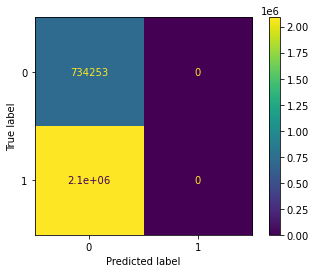

In [113]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [118]:
model = Sequential()
model.add(Dense(units=50, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=200, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
# model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.FalseNegatives(), tf.keras.metrics.Precision()])

In [119]:
model.fit(X_train, y_train)

304634/304634 [==============================] - 2028s 7ms/step - loss: 0.6467 - recall_7: 0.1323 - false_negatives_4: 1059197.5009 - precision_9: 0.9916


In [120]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.2314173085682645
Precision = 0.9999926829714453
Recall = 0.13084914335993245 



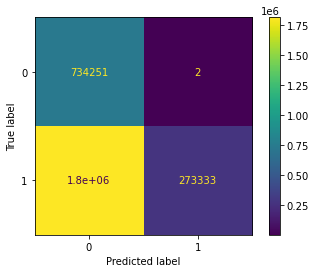

In [121]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

### Trying both again with 60% of positives

#### Undersampling

In [133]:
X_train, X_test, y_train, y_test = get_train_test_dfs('dataset/shuffled/part_6')

In [134]:
len(X_train), len(y_train), len(X_test), len(y_test)

(6587395, 6587395, 2823170, 2823170)

In [135]:
check_distrib(y_train), check_distrib(y_test)

(0.739918890547781, 0.7399189563504854)

In [136]:
train = pd.concat([X_train, y_train], axis=1)
negative = train[train['label'] == 0]
positive = train[train['label'] == 1]
len(negative), len(positive)

(1713257, 4874138)

In [137]:
positive = shuffle_df(positive).iloc[:int(len(negative) * 1.5)]
train = pd.concat([positive, negative])
train = shuffle_df(train)
X_train = train[[i for i in train.columns if i != 'label']]
y_train = train[['label']]

In [138]:
len(X_train)

4283142

In [139]:
check_distrib(y_train)

0.5999999533053072

In [142]:
model = Sequential()
model.add(Dense(units=1, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives()])

In [143]:
model.fit(X_train, y_train)

133849/133849 [==============================] - 585s 4ms/step - loss: 0.6433 - precision_12: 0.5971 - false_positives_2: 427015.1576


In [144]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8506150641390436
Precision = 0.7400728851714885
Recall = 0.9999784577367123 



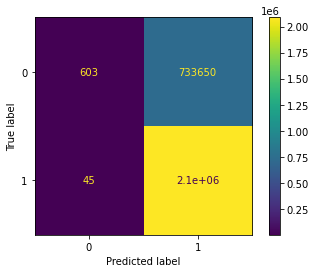

In [145]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [146]:
model = Sequential()
model.add(Dense(units=50, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=200, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
# model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives()])

In [147]:
model.fit(X_train, y_train)

133849/133849 [==============================] - 815s 6ms/step - loss: 0.6327 - precision_13: 0.5992 - false_positives_3: 428830.3528


In [148]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8505211735867056
Precision = 0.7399189563504854
Recall = 1.0 



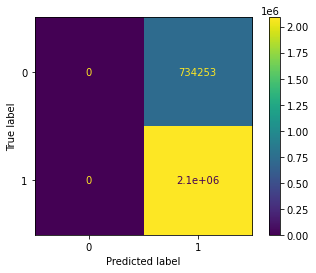

In [149]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

#### Oversampling

In [150]:
X_train, X_test, y_train, y_test = get_train_test_dfs('dataset/shuffled/part_6')

In [151]:
len(X_train), len(y_train), len(X_test), len(y_test)

(6587395, 6587395, 2823170, 2823170)

In [152]:
check_distrib(y_train), check_distrib(y_test)

(0.739918890547781, 0.7399189563504854)

In [153]:
train = pd.concat([X_train, y_train], axis=1)
negative = train[train['label'] == 0]
positive = train[train['label'] == 1]
len(negative), len(positive)

(1713257, 4874138)

In [155]:
neg_upsampled = resample(negative, n_samples=int(0.6666 * len(positive)))

In [156]:
len(neg_upsampled), len(positive)

(3249100, 4874138)

In [157]:
train = pd.concat([neg_upsampled, positive])
train = shuffle_df(train)
X_train = train[[i for i in train.columns if i != 'label']]
y_train = train[['label']]

In [158]:
len(X_train)

8123238

In [159]:
check_distrib(y_train)

0.6000240298265298

In [160]:
model = Sequential()
model.add(Dense(units=1, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives()])

In [161]:
model.fit(X_train, y_train)

253852/253852 [==============================] - 1100s 4ms/step - loss: 0.6731 - precision_14: 0.6006 - false_positives_4: 812435.4165


In [162]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8505211735867056
Precision = 0.7399189563504854
Recall = 1.0 



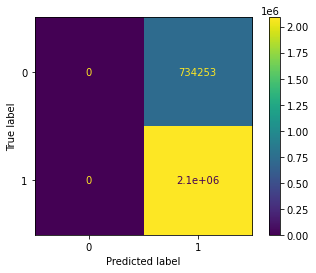

In [163]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)

In [164]:
model = Sequential()
model.add(Dense(units=50, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=200, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=500, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
# model.add(Dropout(0.2))
model.add(Dense(units=100, activation='relu', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.add(Dense(units=1, activation='sigmoid', kernel_regularizer=L1L2(1e-5, 1e-5)))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.FalsePositives()])

In [165]:
model.fit(X_train, y_train)

253852/253852 [==============================] - 1482s 6ms/step - loss: 0.6320 - precision_15: 0.6003 - false_positives_5: 812276.5018


In [166]:
y_pred = model.predict(X_test)
y_pred = np.round(y_pred)

F1 = 0.8505211735867056
Precision = 0.7399189563504854
Recall = 1.0 



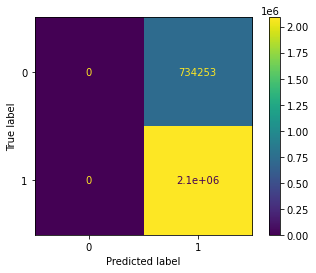

In [168]:
print(f'F1 =', f1_score(y_test, y_pred))
print(f'Precision =', precision_score(y_test, y_pred))
print(f'Recall =', recall_score(y_test, y_pred), '\n')
plot_confusion_matrix(y_test, y_pred)